# Bayesian seats model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Stan-Polling-to-2pp-model" data-toc-modified-id="Stan-Polling-to-2pp-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stan Polling to 2pp model</a></span></li><li><span><a href="#Stan-2pp-difference-to-seats-difference-conversion-model" data-toc-modified-id="Stan-2pp-difference-to-seats-difference-conversion-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stan 2pp-difference to seats-difference conversion model</a></span></li><li><span><a href="#Stan-seats-and-house-outcomes-model" data-toc-modified-id="Stan-seats-and-house-outcomes-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Stan seats and house outcomes model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Visualise-results" data-toc-modified-id="Visualise-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualise results</a></span><ul class="toc-item"><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>House outcome</a></span></li><li><span><a href="#Model-for-non-major-party-members" data-toc-modified-id="Model-for-non-major-party-members-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Model for non-major party members</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib
import math

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

In [4]:
# data locations
SEAT_HISTORY_FILE = '../data/Seat History.csv'

## Supporting functions

In [5]:
def plot_finalise(ax, title=None, xlabel=None, ylabel=None, lfooter=None):
    
    # annotate the plot
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if lfooter is not None:
        ax.figure.text(0.005, 0.005, lfooter, 
                       ha='left', va='bottom',
                       c='#999999', style='italic', 
                       fontsize=10)
        
    ax.figure.tight_layout(pad=1.1)    
    
    ax.figure.savefig(CHART_DIR+title+'.png', dpi=300)
    
    # close
    plt.show()
    plt.close()

## Get the data

Note: the data was produced by the "capture wiki election history data and preliminary charts" notebook.

In [6]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [7]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [8]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [9]:
seat_history['Proportion of others'] = (
    seat_history[('Seats',  'Oth.')] 
    / seat_history[('Seats', 'Total')]
)

In [10]:
# limit input data to recent history
HISTORY_START = 1969 # let's start with Don's party ...
seat_history = seat_history[seat_history.index.year >= HISTORY_START]

In [11]:
# limit autoregressive model of non-major party members to an even more recent period
seat_history['Row number'] = range(1, len(seat_history)+1)
AUTOREGRESS_FROM = 1993 # previous election non-zero, also subsequent also non-zero
assert(AUTOREGRESS_FROM >= HISTORY_START)
ar_from = seat_history.loc[seat_history.index.year == AUTOREGRESS_FROM, 'Row number'].values[0]
ar_from

11

In [12]:
len(seat_history)

20

## Stan Polling to 2pp model

Still to be written

In [13]:
# TO DO

## Stan 2pp-difference to seats-difference conversion model

In [14]:
conversion_data = {
    'tpp': 0.47, # Still to code a polling model

    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
}

In [15]:
conversion_model = """
data {
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp
    
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)
}

parameters {
    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=0.000001> sigma; // force half cauchy with lower bound  
}

model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);      
    sigma ~ cauchy(0, 1);

    // linear regression from 2pp vote difference to seats difference
    // use student_t here for the fatter tails ...
    seats ~ student_t(5, intercept + (slope * votes), sigma); // fatter tails
    //seats ~ normal(intercept + (slope * votes), sigma); // normal dist.   
}

generated quantities {

    // --- MODEL DIAGNOSTICS ---
    
    // 2pp to seats relationship
    vector<lower=-1,upper=1>[n_history] seats_estimate;
    seats_estimate = slope * votes + intercept;
    
    // prediction interval on 2pp to seats relationship
    real<lower=-1,upper=1> predict_interval[n_history] = 
        normal_rng(intercept + (slope * votes), sigma);
}
"""

In [16]:
conv_posterior = stan.build(conversion_model, data=conversion_data)

# Note: Stan typically produces an ocean of compiler warnings.
#       For the most part these are utterly _useless_ warnings.
#       But there may be an important parser diagnostic that 
#       requres action buried among the blathering. Searching
#.      for "PARSER" and "DIAGNOSTIC" can help find if there is 
#.      something of concern.
#       https://mc-stan.org/misc/warnings.html#compiler-warnings

Building: found in cache, done.


In [17]:
conv_fit = conv_posterior.sample(num_chains=4, num_samples=25_000)

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


In [18]:
az.summary(conv_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.353,0.309,2.753,3.922,0.001,0.001,77791.0,63617.0,1.0
intercept,0.036,0.017,0.003,0.067,0.000,0.000,81783.0,66766.0,1.0
sigma,0.065,0.014,0.041,0.090,0.000,0.000,75066.0,69313.0,1.0
seats_estimate[0],0.022,0.017,-0.010,0.055,0.000,0.000,80306.0,67070.0,1.0
seats_estimate[1],-0.145,0.026,-0.193,-0.097,0.000,0.000,72065.0,62644.0,1.0
seats_estimate[2],0.150,0.018,0.115,0.184,0.000,0.000,92627.0,67938.0,1.0
seats_estimate[3],0.418,0.037,0.348,0.486,0.000,0.000,87768.0,65803.0,1.0
seats_estimate[4],0.344,0.031,0.284,0.400,0.000,0.000,89715.0,65673.0,1.0
seats_estimate[5],0.062,0.017,0.031,0.094,0.000,0.000,84934.0,67104.0,1.0
seats_estimate[6],-0.179,0.028,-0.231,-0.126,0.000,0.000,71894.0,62334.0,1.0


array([[<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

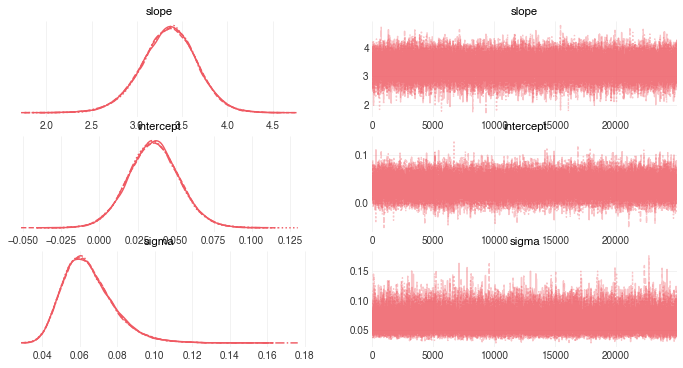

In [19]:
az.plot_trace(conv_fit, var_names=['slope', 'intercept', 'sigma',])

In [20]:
conv_results_df = conv_fit.to_frame()

In [21]:
# extract key variables for next step ...
conv_slope = conv_results_df['slope'].median()
conv_intercept = conv_results_df['intercept'].median()
conv_sigma = conv_results_df['sigma'].median()

# What is our conversion formula ...
conv_formula = (
    f'y = {round(conv_slope, 4)}x + {round(conv_intercept, 4)};  '
    f'σ = {round(conv_sigma, 4)}'
)
conv_formula

'y = 3.3613x + 0.0355;  σ = 0.0627'

In [22]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW = 'low'
HIGH = 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [23]:
def get_estimates_quants(pattern):

    # Get seat estimate quantiles
    seat_estimate = (
        conv_results_df[conv_results_df.columns[
            conv_results_df.columns.str.contains(pattern)
        ]]
    )
    seat_estimate.columns = seat_history.index
    seat_estimate = seat_estimate.quantile(quants).T

    # link to votes
    seat_estimate['2pp votes'] = seat_history['Govt 2pp votes margin']
    seat_estimate = seat_estimate.sort_values('2pp votes')
    
    return seat_estimate
        
estimates = get_estimates_quants('seats_estimate')

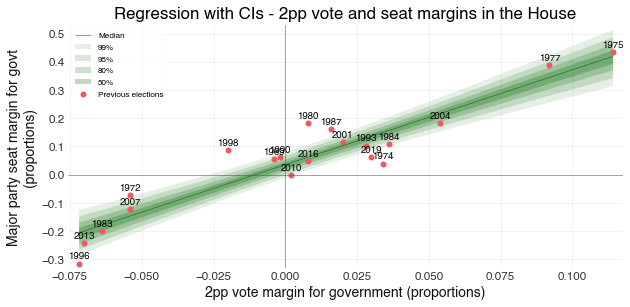

In [24]:
def plot_est_quants(estimates, title, **kwargs):
    # plot this relationship
    fig, ax = plt.subplots()
    ax.margins(0.02)
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = estimates[low]
        highpoint = estimates[high]
        ax.fill_between(x=estimates['2pp votes'], y1=lowpoint, y2=highpoint,
                    color='darkgreen', alpha = alpha, label=x,)
        alpha += 0.05
    
    ax.plot(estimates['2pp votes'], estimates[0.500], 
        color='darkgreen', lw=0.5, label='Median')

    ax.scatter(seat_history['Govt 2pp votes margin'],
               seat_history['Govt seats margin'],
               label='Previous elections')

    ax.axhline(0, lw=0.5, color='#555555')
    ax.axvline(0, lw=0.5, color='#555555')

    for x, y, s in zip(seat_history['Govt 2pp votes margin'],
                       seat_history['Govt seats margin']+0.01,
                       seat_history.index.year.astype(str)):
        ax.text(x, y, s, fontsize='x-small', va='bottom', ha='center')
    

    ax.legend(loc='best')
    plot_finalise(ax, 
                  title=title,
                  xlabel='2pp vote margin for government (proportions)', 
                  ylabel='Major party seat margin for govt\n(proportions)',
                  **kwargs)

plot_est_quants(estimates, 
                'Regression with CIs - 2pp vote and seat margins in the House')

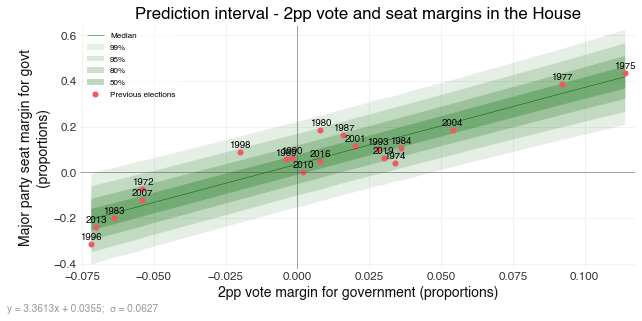

In [25]:
predictions = get_estimates_quants('predict_interval')
plot_est_quants(predictions, 
                'Prediction interval - 2pp vote and seat margins in the House',
                lfooter=conv_formula)

## Stan seats and house outcomes model

In [26]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'tpp': 0.47, # Still to code a polling model

    'conv_slope': conv_slope,
    'conv_intercept': conv_intercept,
    'conv_sigma': conv_sigma,
    
    'n_seats': SEATS_NEXT_PARLIAMENT,
    'n_history': len(seat_history),
    'win_threshold': WIN_THRESHOLD,
    'others': seat_history['Proportion of others'].values,
    'ar_from': ar_from,
}

In [27]:
seats_model = """
data {

    // input from the polling model
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp

    // input from the conversion model
    real conv_slope;
    real conv_intercept;
    real<lower=0.000001> conv_sigma; // must be non-zero positive

    // inputs for this model
    int<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    int<lower=1> n_history;    // length of election history
    vector<lower=0,upper=1>[n_history] others;
    int<lower=1> ar_from;
}

parameters {
    // auto regressive, this year is much like last year
    real drift;
    real replication;
    real<lower=0.000001> s; // force half cauchy with lower bound
}

model {
    // priors on auto-regressive non-major-party seat proportion
    // --- this is not a great model in the circumstances
    drift ~ normal(0.0, 0.1);     // informative prior
    replication ~ normal(1, 0.1); // informative prior
    s ~ cauchy(0, 10);

    // limited autoregressive(1) model over recent data
    // for proportion of non-major-party seats
    others[ar_from:n_history] ~  
        normal(drift + (replication * others[(ar_from-1):(n_history-1)]), s);
}

generated quantities {

    // --- 2022 FORECAST ---

    // seats won by other parties
    real<lower=0,upper=n_seats> other_seats = 
        (drift + (replication * others[n_history])) * n_seats;

    // seats remaining available for the Coalition and Labor
    real<lower=0,upper=n_seats> available_seats = n_seats - other_seats;

    // Given the Coalition's TPP, how many seats will the Coalition/Govt win?
    // Note: regression based on student_t, but prediction is from normal.
    real seats_forecast = 
        normal_rng(conv_slope * (tpp - (1 - tpp)) + conv_intercept, conv_sigma);
    
    real<lower=0,upper=n_seats> government_seats = 
        (available_seats / 2)
        + (seats_forecast * (available_seats / 2));

    // Labor seats = total seats - other seats - Coalition seats
    real<lower=0,upper=n_seats> opposition_seats = 
        (available_seats - government_seats);

    // How often does the Coalition government win the election?
    int<lower=0,upper=1> government_wins = government_seats > win_threshold ? 1 : 0;

    // How often does the Labor opposition win?
    int<lower=0,upper=1> opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    // How often do we get a hung parliament?
    int<lower=0,upper=1> hung_parliament = 
        (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [28]:
posterior = stan.build(seats_model, data=seats_data)

Building: found in cache, done.


In [29]:
fit = posterior.sample(num_chains=4, num_samples=25_000)

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 0.001438 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001435 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Exception: model_gggnuf3y_namespace::write_array: other_seats is -0.346488, but must be greater than or equal to 0.000000 (in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan__kouj1ed/model_gggnuf3y.stan', line 45, column 4 to line 46, column 62)
  Gradient evaluation took 9e-

## Diagnostics

In [30]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
drift,0.004,0.006,-0.008,0.016,0.000,0.000,60028.0,57638.0,1.0
replication,0.961,0.100,0.771,1.145,0.000,0.000,63031.0,59453.0,1.0
s,0.018,0.005,0.010,0.027,0.000,0.000,55113.0,52010.0,1.0
other_seats,6.391,0.913,4.666,8.134,0.004,0.003,71223.0,56461.0,1.0
available_seats,144.608,1.021,142.866,146.334,0.004,0.003,71311.0,56433.0,1.0
seats_forecast,-0.167,0.063,-0.285,-0.049,0.000,0.000,99826.0,98156.0,1.0
government_seats,60.252,4.553,51.570,68.673,0.014,0.010,99641.0,98320.0,1.0
opposition_seats,84.355,4.566,75.771,92.889,0.014,0.010,99521.0,98569.0,1.0
government_wins,0.000,0.022,0.000,0.000,0.000,0.000,100107.0,100107.0,1.0
opposition_wins,0.974,0.159,1.000,1.000,0.001,0.000,101032.0,100000.0,1.0


array([[<AxesSubplot:title={'center':'drift'}>,
        <AxesSubplot:title={'center':'drift'}>],
       [<AxesSubplot:title={'center':'replication'}>,
        <AxesSubplot:title={'center':'replication'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
        <AxesSubplot:title={'center':'government_wins'}>],
       [<AxesSubplot:title={'center':'opposition_wins'}>,
        <AxesSubplot:title={'center':'opposition_wins'}>],
       [<AxesSubplot:title={'center':'hung_parliament'}>,
        <AxesSubplot:title={'center':'hung_parliament'}>]], dtype=

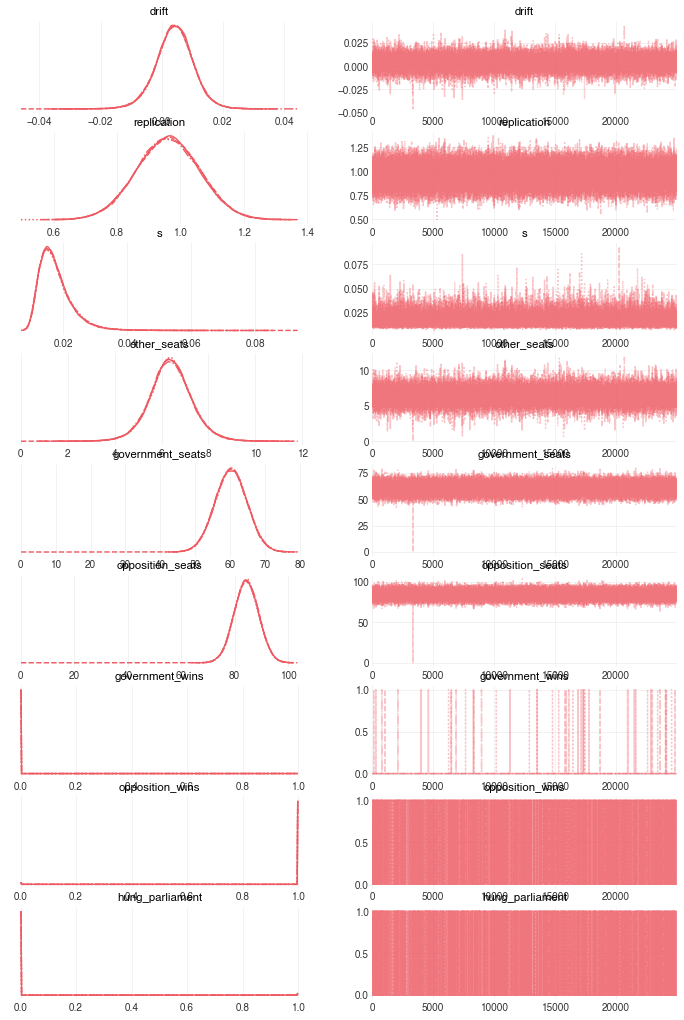

In [31]:
az.plot_trace(fit, var_names=['drift', 'replication', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualise results

In [32]:
results_df = fit.to_frame()

In [33]:
results_df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'drift', 'replication', 's', 'other_seats',
       'available_seats', 'seats_forecast', 'government_seats',
       'opposition_seats', 'government_wins', 'opposition_wins',
       'hung_parliament'],
      dtype='object', name='parameters')

In [34]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    outright_win = sw[sw.index > WIN_THRESHOLD].sum() / sw.sum()
    lfooter = f'Outright win probability = {round(outright_win, 5)}'
    sw.index = sw.index.astype(int)
    _, ax = plt.subplots()
    ax.margins(0.02)
    ax.bar(x=sw.index, height=sw, color=colour)
    
    xlim = ax.get_xlim()
    if xlim[0] < WIN_THRESHOLD < xlim[1]:
        ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')
    
    plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability',
                 lfooter=lfooter)

### Seats won

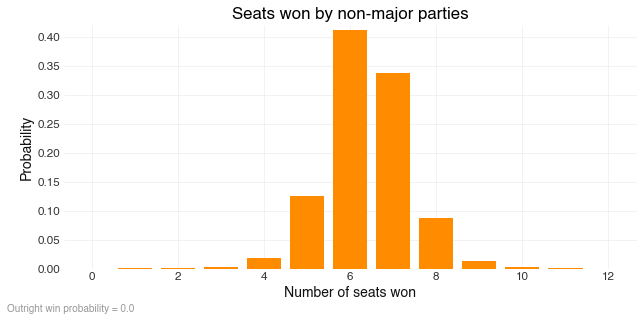

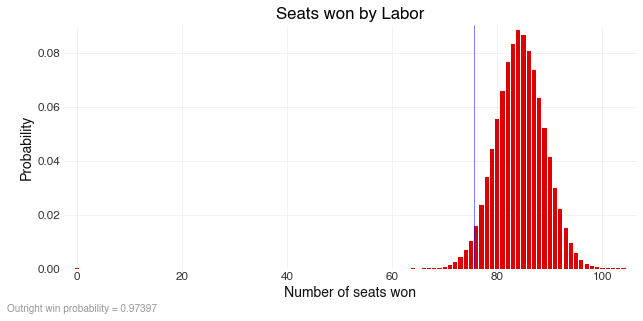

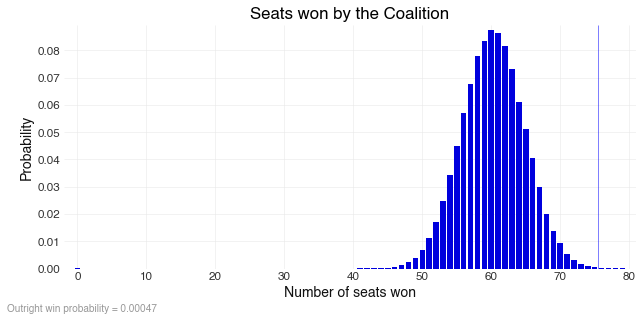

In [35]:
plot_seats_won('other_seats', 'Seats won by non-major parties', 'darkorange')
plot_seats_won('opposition_seats', 'Seats won by Labor', '#dd0000')
plot_seats_won('government_seats', 'Seats won by the Coalition', '#0000dd')

### House outcome

parameters
Labour Wins Outright       0.97398
Hung Parliament            0.02555
Coalition Wins Outright    0.00047
dtype: float64


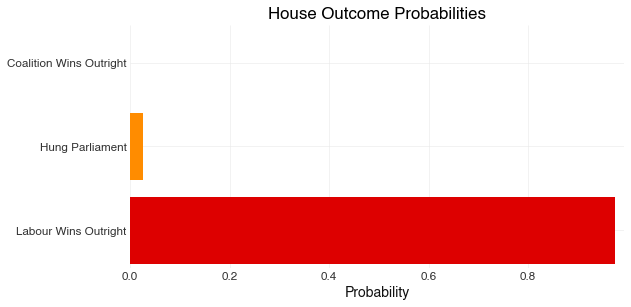

In [36]:
# probabilities for the types of house outcomes
ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
renamer = {
    'opposition_wins': 'Labour Wins Outright',
    'hung_parliament': 'Hung Parliament',
    'government_wins': 'Coalition Wins Outright',
}
ho = ho.rename(index=renamer)
order = list(renamer.values())
ho = (ho / ho.sum())[order]
print(ho)
_, ax = plt.subplots()
ax.margins(0.02)

colors = ['#dd0000', 'darkorange', '#0000dd', ]
ax.barh(ho.index, ho, color=colors)
plot_finalise(ax, 'House Outcome Probabilities',
              ylabel=None,
              xlabel='Probability')

adjusting up


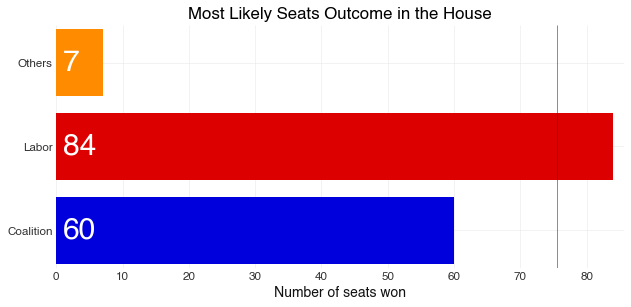

In [37]:
# Most likely house outcome
def plot_likely_house_seats_outcome():
    parties = ['government_seats', 'opposition_seats', 'other_seats']
    xparties = ['Coalition', 'Labor', 'Others']
    bar_dict = {}
    for p, x in zip(parties, xparties):
        bar_dict[x] = results_df[p].median()
    series = pd.Series(bar_dict)

    # check for jankie rounding errors
    rounded = series.round(0).astype(int)
    if rounded.sum() < SEATS_NEXT_PARLIAMENT:
        print('adjusting up')
        bless = (
            (series + 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=False).index[0]
        )
        rounded[bless] = rounded[bless] + 1
    if rounded.sum() > SEATS_NEXT_PARLIAMENT:
        print('adjusting down')
        bless = (
            (series - 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=True).index[0]
        )
        rounded[bless] = rounded[bless] - 1

    # plot
    fig, ax = plt.subplots()
    ax.margins(0.02)
    colors = ['#0000dd', '#dd0000', 'darkorange']
    ax.barh(rounded.index, rounded, color=colors)
    ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')

    for index, value in rounded.iteritems():
        ax.text(x=1, y=index, s=str(value), c='w', fontsize=30,
                ha='left', va='center')

    plot_finalise(ax, 
                  title='Most Likely Seats Outcome in the House',
                  xlabel='Number of seats won',
                  ylabel=None)

plot_likely_house_seats_outcome()

### Model for non-major party members

Trend over recent years has been increasing representation, but overall, this year's numbers are much like last years. At hthe moment, this modelled with autoregressive(1) model.

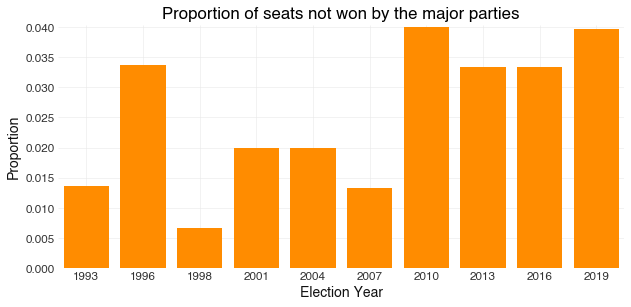

In [38]:
# Historical data as a bar chart
data = seat_history.loc[seat_history['Row number'] >= ar_from, 
                        'Proportion of others']
fig, ax = plt.subplots()
ax.margins(0.01)
ax.bar(x=[str(x) for x in data.index.year],
       height=data.values, color='darkorange')

plot_finalise(ax, 
              title='Proportion of seats not won by the major parties',
              xlabel='Election Year', 
              ylabel='Proportion',)
